# Pathway associated gene expression heatmap

This notebook will use heatmaps to visualize the gene expression for selected genes that correspond to selected pathways. These pathways have been selected for their roles in tumor proliferation and chemotherapy resistance.

1. Tumor Proliferation
    1. G2/M Cell Cycle Checkpoint
    2. E2F Regulation
2. Chemotherapy Resistance
    1. DNA Damage Response (DDR)
    2. Unfolded Protein Response (UPR)

For these heatmaps, the combined epethilial dataset does **not** filter out the following:

* Stromal cells
   * This cell type is located in connective tissues. [9]
   * "Source of cancer-associated fibroblasts" [9, 10]
* Genes with low variance across cells
   * The two types of cells being analyzed have different descriptive statistics which contributes to the likelihood that filtering out highly variable genes for each of these groups will be more difficult to compare.
   * The interest in this notebook is biolical signifcance and/or relevance. Keeping these genes ensures that key insights aren't missed just because they don't drive variance across all the cells.

## Raw gene expressions

Heatmaps will be generated from the raw expression of hallmark gene signatures for the pathways.

1. Tumor Proliferation
    1. G2/M Cell Cycle Checkpoint - `HALLMARK_G2M_CHECKPOINT.v2025.1.Hs.gmt`
    2. E2F Regulation - `HALLMARK_E2F_TARGETS.v2025.1.Hs.gmt`
2. Chemotherapy Resistance
    1. DNA Damage Response (DDR) - `HALLMARK_DNA_REPAIR.v2025.1.Hs.gmt`
    2. Unfolded Protein Response (UPR) - `HALLMARK_UNFOLDED_PROTEIN_RESPONSE.v2025.1.Hs.gmt`

This is supported by creating a read-only snapshot of the expression was created before any filtering and joining.

## 0. Initializations

In [15]:
# -- imports --
import anndata as ad
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scanpy as sc

from signals_in_the_noise.preprocessing.gse161529 import GSE161529
from signals_in_the_noise.utilities.storage import get_resources_path
from signals_in_the_noise.utilities.visualization import get_figure_axes

In [16]:
# -- datasets --
gse = GSE161529()

2025-08-12 18:07:00,706 [INFO] signals_in_the_noise.utilities.tenx_genomics: Reading C:\Users\silly\GitHub\signals-in-the-noise\data\GSE161529_adata_cache\GSM4909253_N-PM0092-Total.h5ad as AnnData object.
2025-08-12 18:07:00,808 [INFO] signals_in_the_noise.utilities.tenx_genomics: Reading C:\Users\silly\GitHub\signals-in-the-noise\data\GSE161529_adata_cache\GSM4909254_N-PM0019-Total.h5ad as AnnData object.
2025-08-12 18:07:00,971 [INFO] signals_in_the_noise.utilities.tenx_genomics: Reading C:\Users\silly\GitHub\signals-in-the-noise\data\GSE161529_adata_cache\GSM4909255_N-N280-Epi.h5ad as AnnData object.
2025-08-12 18:07:01,026 [INFO] signals_in_the_noise.utilities.tenx_genomics: Reading C:\Users\silly\GitHub\signals-in-the-noise\data\GSE161529_adata_cache\GSM4909256_N-PM0095-Epi.h5ad as AnnData object.
2025-08-12 18:07:01,192 [INFO] signals_in_the_noise.utilities.tenx_genomics: Reading C:\Users\silly\GitHub\signals-in-the-noise\data\GSE161529_adata_cache\GSM4909257_N-PM0095-Total.h5ad 

In [17]:
all_real, all_noise = gse.get_combined_epithilial_dataset(
    real_filename="combined_epi_normal_pathway_real.h5ad",
    noise_filename="combined_epi_normal_pathway_noise.h5ad",
    remove_stromal=False,
)

2025-08-12 18:07:11,870 [INFO] signals_in_the_noise.preprocessing.gse161529: Loading combined datasets...


In [18]:
# -- genes for pathways --
pathway_to_gmt = {
    'ddr': 'HALLMARK_DNA_REPAIR.v2025.1.Hs.gmt',
    'e2f': 'HALLMARK_E2F_TARGETS.v2025.1.Hs.gmt',
    'g2m': 'HALLMARK_G2M_CHECKPOINT.v2025.1.Hs.gmt',
    'upr': 'HALLMARK_UNFOLDED_PROTEIN_RESPONSE.v2025.1.Hs.gmt',
    'p53': 'HALLMARK_P53_PATHWAY.v2025.1.Hs.gmt',
}

# -- load genes --
from collections import defaultdict
pathway_to_genes = defaultdict(list)
for gmt_file in pathway_to_gmt.values():
    gmt_path = get_resources_path("/".join([gse.STUDY_ID, 'gene_set_enrichment_analysis', gmt_file]))
    with open(gmt_path, 'r') as input_file:
        content = input_file.read()
        content = content.split()
        pathway_to_genes[content[0]] = content[2:]

In [19]:
def pathway_heatmap(adata, pathway_name, pathway_genes):
    # filter pathway genes for ones that appear in dataset
    actual_pathway_genes = [gene for gene in pathway_genes if gene in adata.var_names]
    pathway_genes_split = np.array_split(actual_pathway_genes, 2)

    # create dataframes to display
    heatmaps = []
    for genes in pathway_genes_split:
        pathway_df = pd.DataFrame(
            adata[:, genes].X.toarray(),
            index=adata.obs_names,
            columns=genes
        )
        pathway_df['specimen_id'] = adata.obs['specimen_id'].values
        # Group by specimen_id and take the mean (like Scanpy's groupby)
        heatmap_data = pathway_df.groupby("specimen_id").mean()
        heatmaps.append(heatmap_data)

    _, axes = get_figure_axes(2, num_cols=1, subplot_size=(60, 5), share_y=True, super_title=f"Mean Raw Expressions of Genes Grouped by Specimen ID\n{pathway_name}")
    for idx, ax in enumerate(axes):
        sns.heatmap(
            heatmaps[idx],
            cmap='rocket',
            ax=ax,
            cbar_kws={'pad': 0.02},
        )

    plt.xlabel("Gene Set")
    plt.ylabel("Specimen")
    plt.show()

## 1. Tumor Proliferation

1. Tumor Proliferation
    1. G2/M Cell Cycle Checkpoint - `HALLMARK_G2M_CHECKPOINT.v2025.1.Hs.gmt`
    2. E2F Regulation - `HALLMARK_E2F_TARGETS.v2025.1.Hs.gmt`

### 1.a. "Real" cells

C:\Users\silly\AppData\Local\Temp\ipykernel_34936\360744347.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = pathway_df.groupby("specimen_id").mean()
C:\Users\silly\AppData\Local\Temp\ipykernel_34936\360744347.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = pathway_df.groupby("specimen_id").mean()


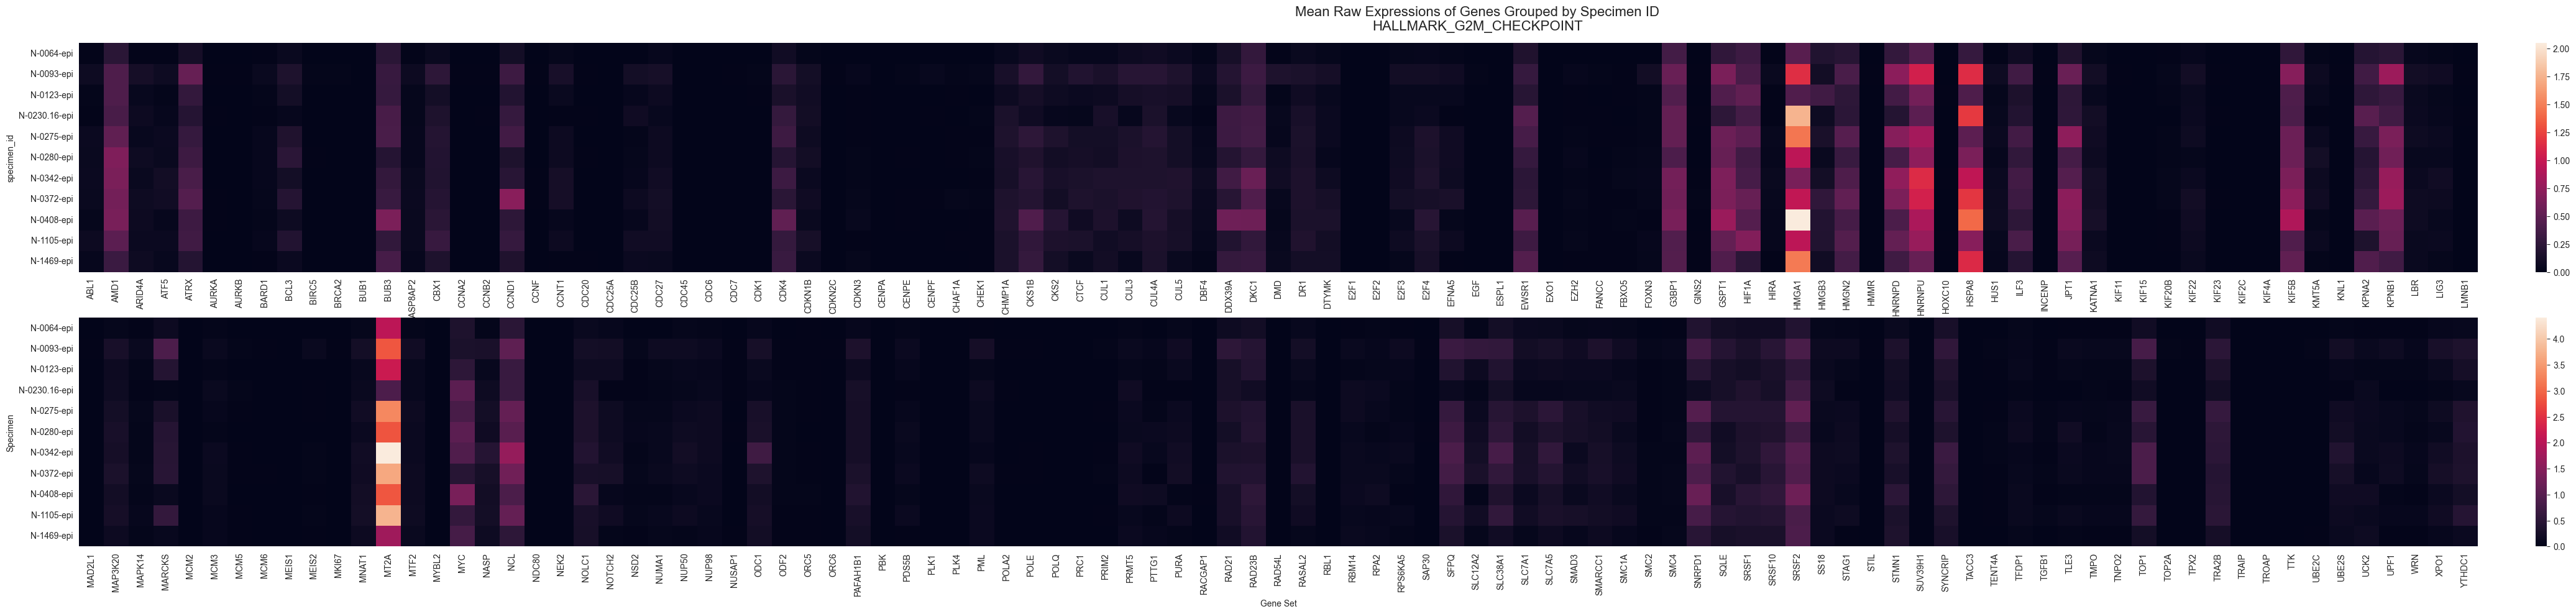

In [20]:
pathway_name = 'HALLMARK_G2M_CHECKPOINT'
pathway_genes = pathway_to_genes[pathway_name]
pathway_heatmap(all_real, pathway_name, pathway_genes)

C:\Users\silly\AppData\Local\Temp\ipykernel_34936\360744347.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = pathway_df.groupby("specimen_id").mean()
C:\Users\silly\AppData\Local\Temp\ipykernel_34936\360744347.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = pathway_df.groupby("specimen_id").mean()


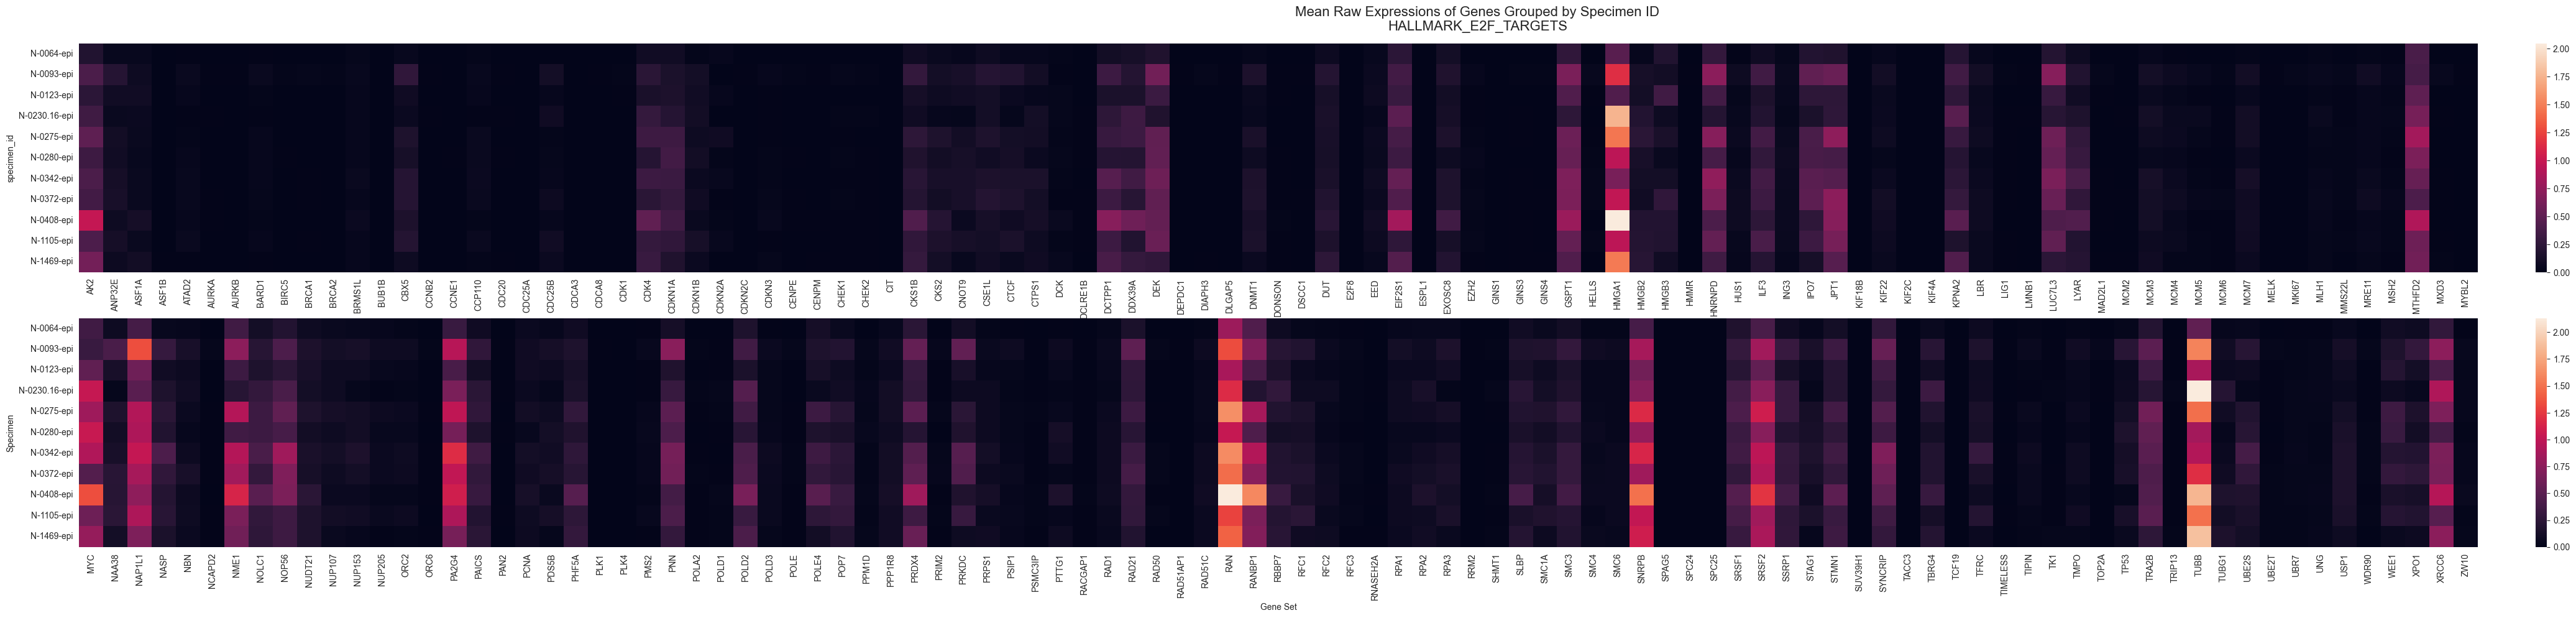

In [21]:
pathway_name = 'HALLMARK_E2F_TARGETS'
pathway_genes = pathway_to_genes[pathway_name]
pathway_heatmap(all_real, pathway_name, pathway_genes)

### 1.b. "Noise" cells

C:\Users\silly\AppData\Local\Temp\ipykernel_34936\360744347.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = pathway_df.groupby("specimen_id").mean()
C:\Users\silly\AppData\Local\Temp\ipykernel_34936\360744347.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = pathway_df.groupby("specimen_id").mean()


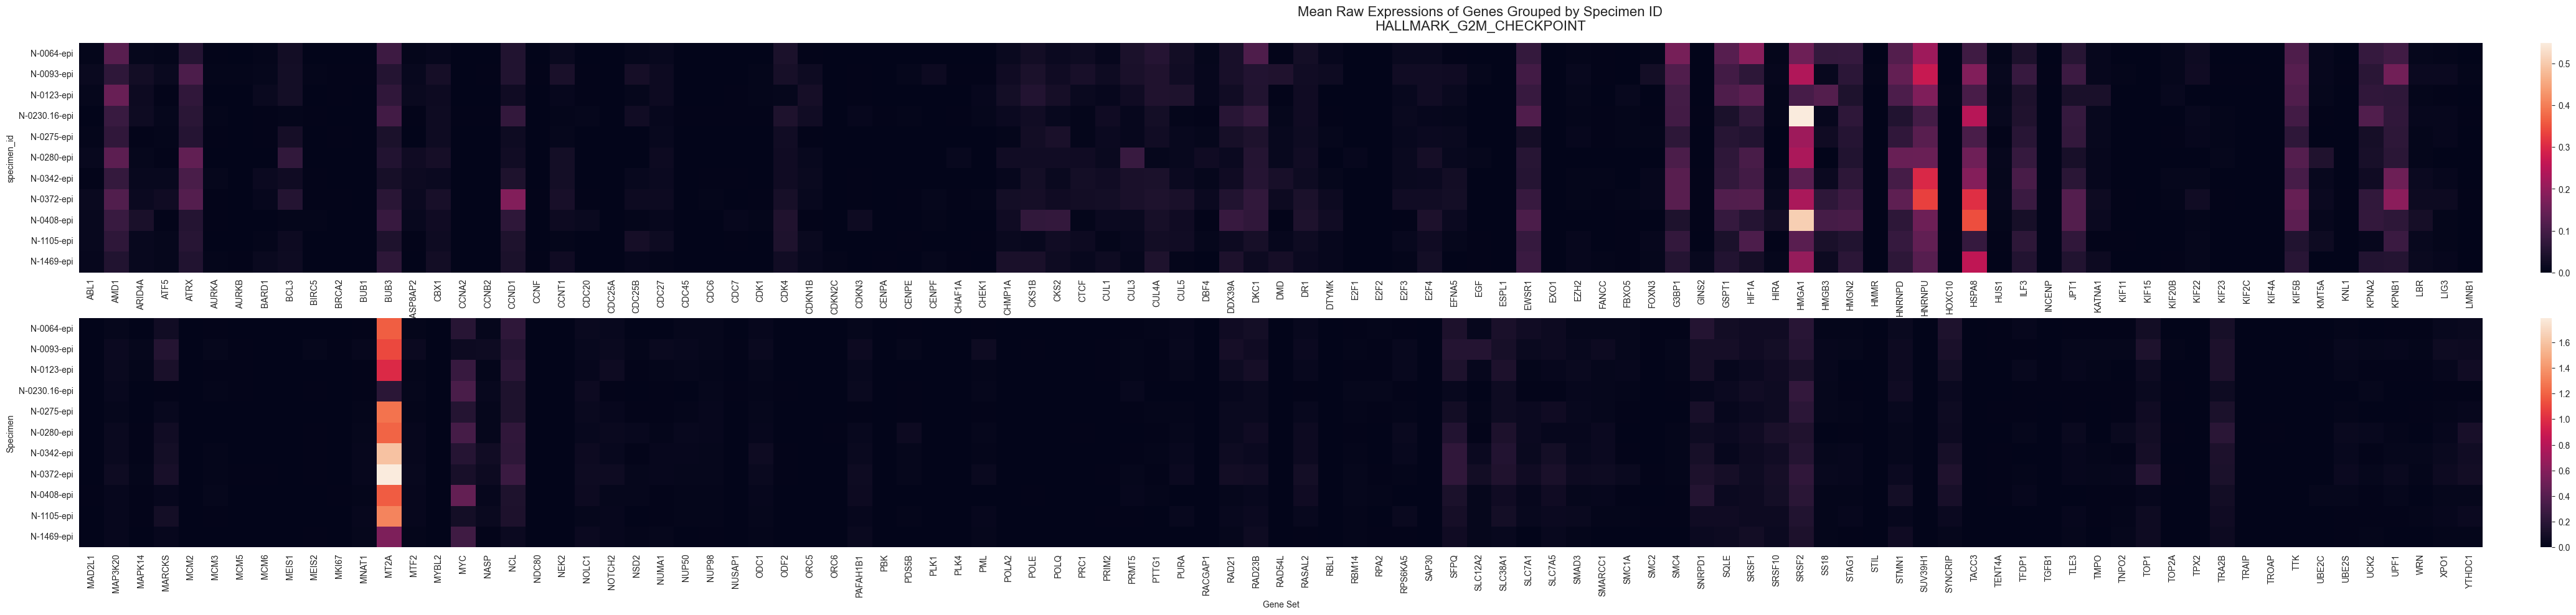

In [22]:
pathway_name = 'HALLMARK_G2M_CHECKPOINT'
pathway_genes = pathway_to_genes[pathway_name]
pathway_heatmap(all_noise, pathway_name, pathway_genes)

C:\Users\silly\AppData\Local\Temp\ipykernel_34936\360744347.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = pathway_df.groupby("specimen_id").mean()
C:\Users\silly\AppData\Local\Temp\ipykernel_34936\360744347.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = pathway_df.groupby("specimen_id").mean()


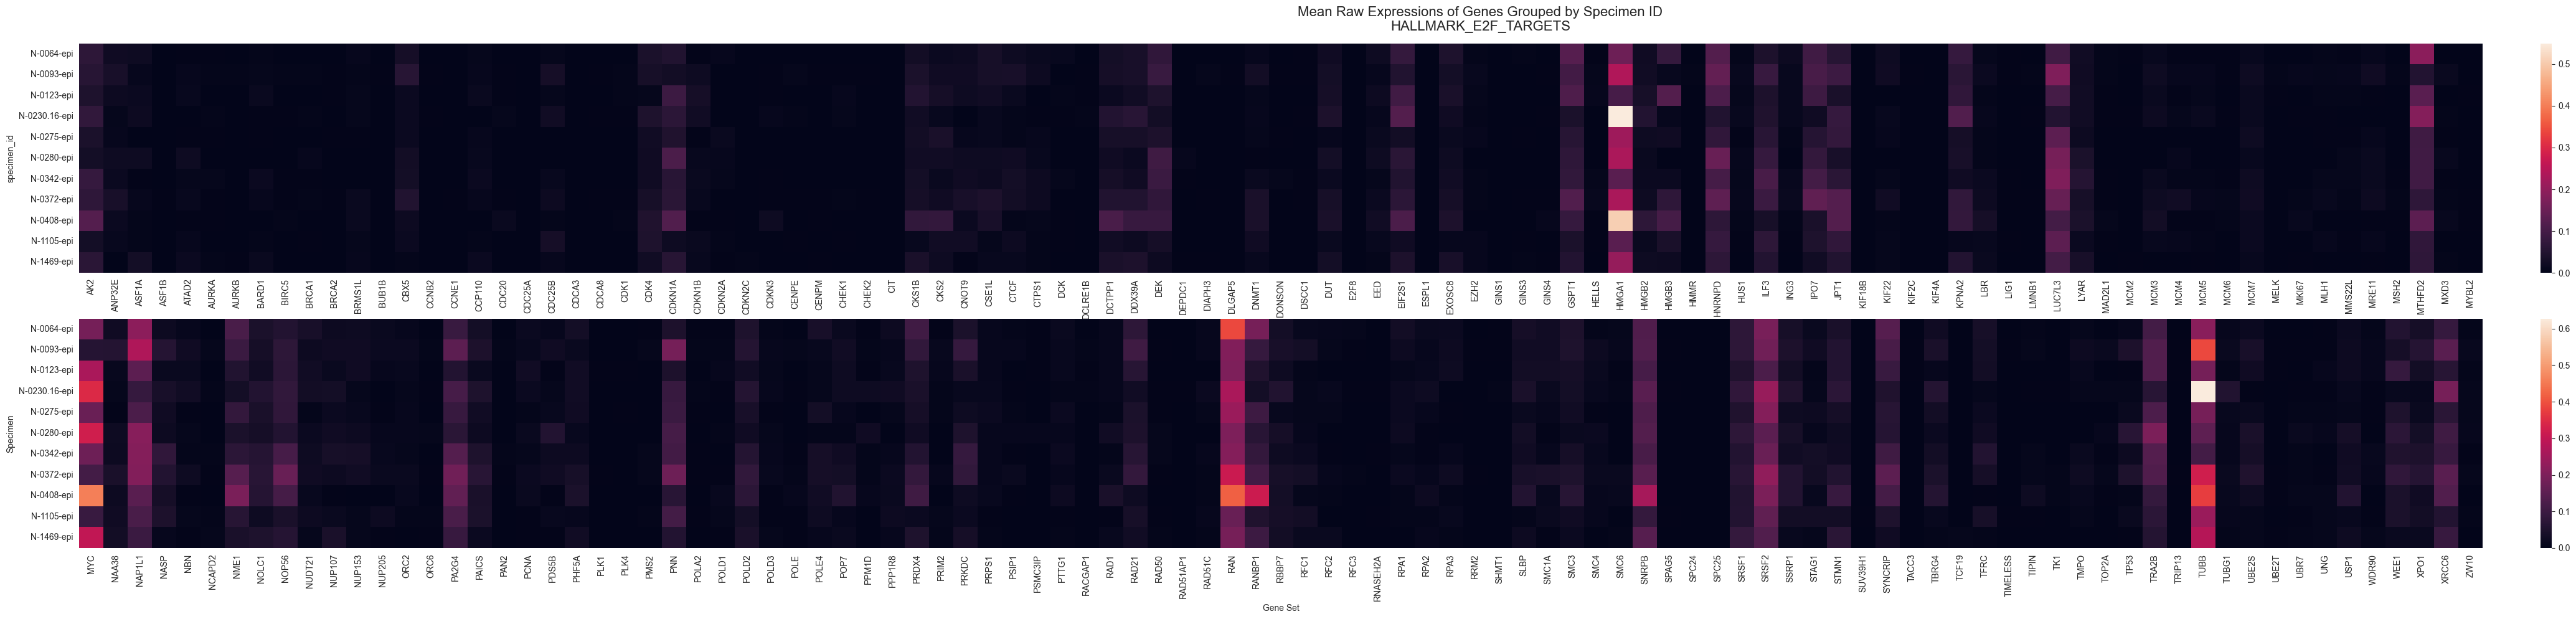

In [23]:
pathway_name = 'HALLMARK_E2F_TARGETS'
pathway_genes = pathway_to_genes[pathway_name]
pathway_heatmap(all_noise, pathway_name, pathway_genes)

## 2. Chemotherapy Resistance genes

2. Chemotherapy Resistance
    1. DNA Damage Response (DDR) - `HALLMARK_DNA_REPAIR.v2025.1.Hs.gmt`
    2. Unfolded Protein Response (UPR) - `HALLMARK_UNFOLDED_PROTEIN_RESPONSE.v2025.1.Hs.gmt`

### 2.a. "Real" cells

C:\Users\silly\AppData\Local\Temp\ipykernel_34936\360744347.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = pathway_df.groupby("specimen_id").mean()
C:\Users\silly\AppData\Local\Temp\ipykernel_34936\360744347.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = pathway_df.groupby("specimen_id").mean()


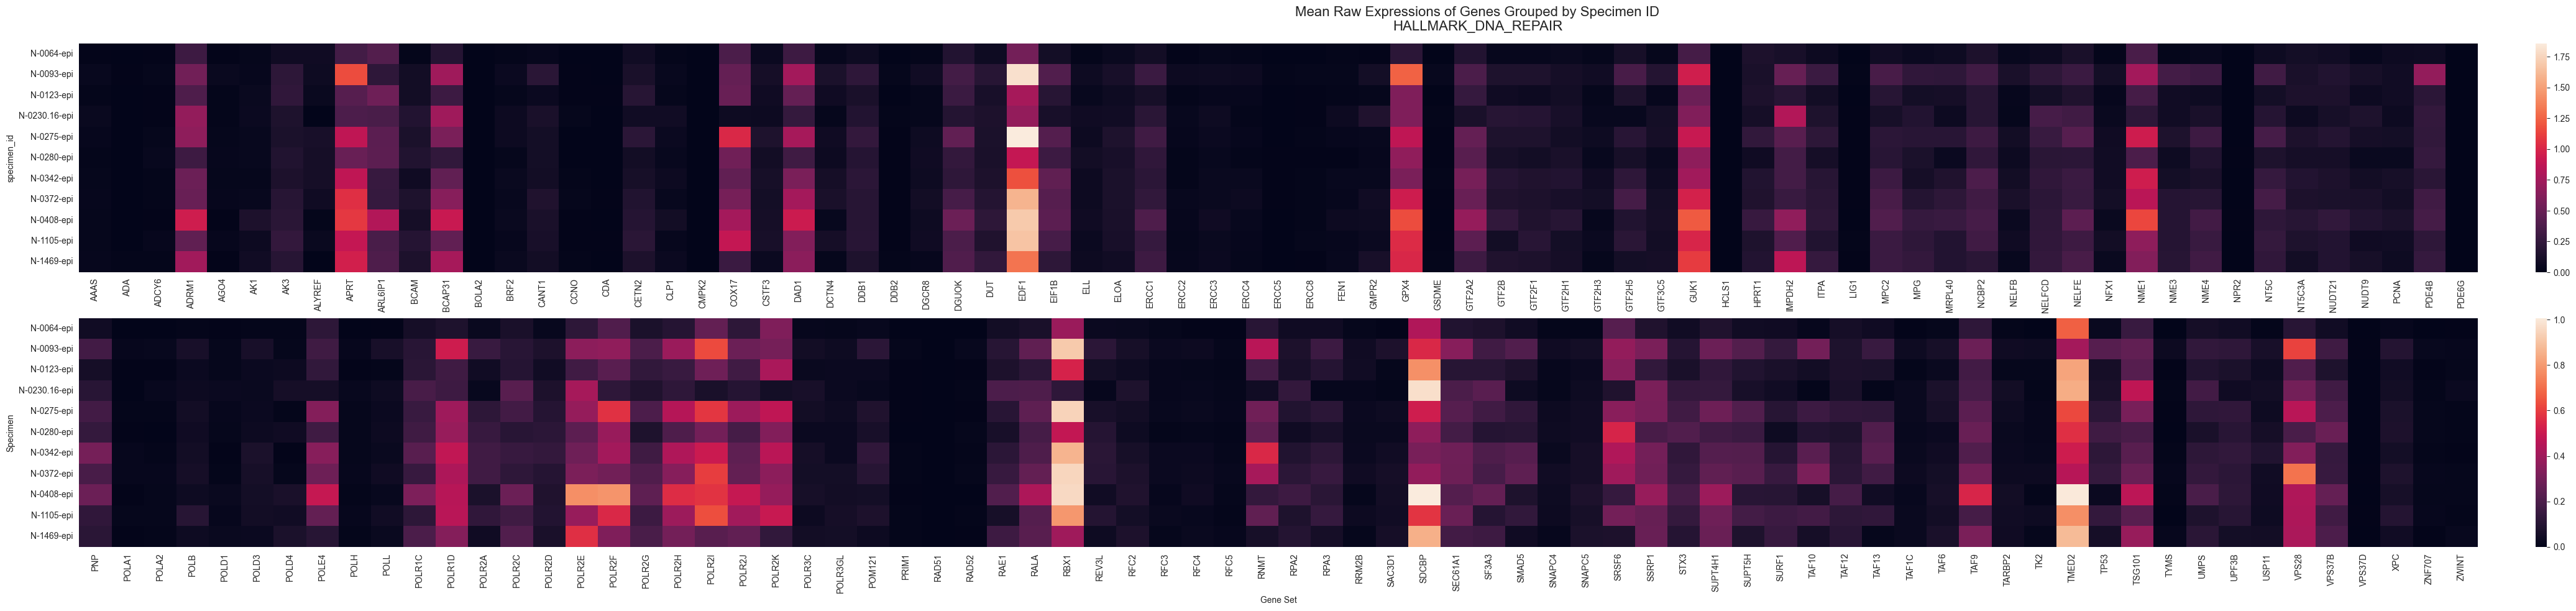

In [24]:
pathway_name = 'HALLMARK_DNA_REPAIR'
pathway_genes = pathway_to_genes[pathway_name]
pathway_heatmap(all_real, pathway_name, pathway_genes)

C:\Users\silly\AppData\Local\Temp\ipykernel_34936\360744347.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = pathway_df.groupby("specimen_id").mean()
C:\Users\silly\AppData\Local\Temp\ipykernel_34936\360744347.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = pathway_df.groupby("specimen_id").mean()


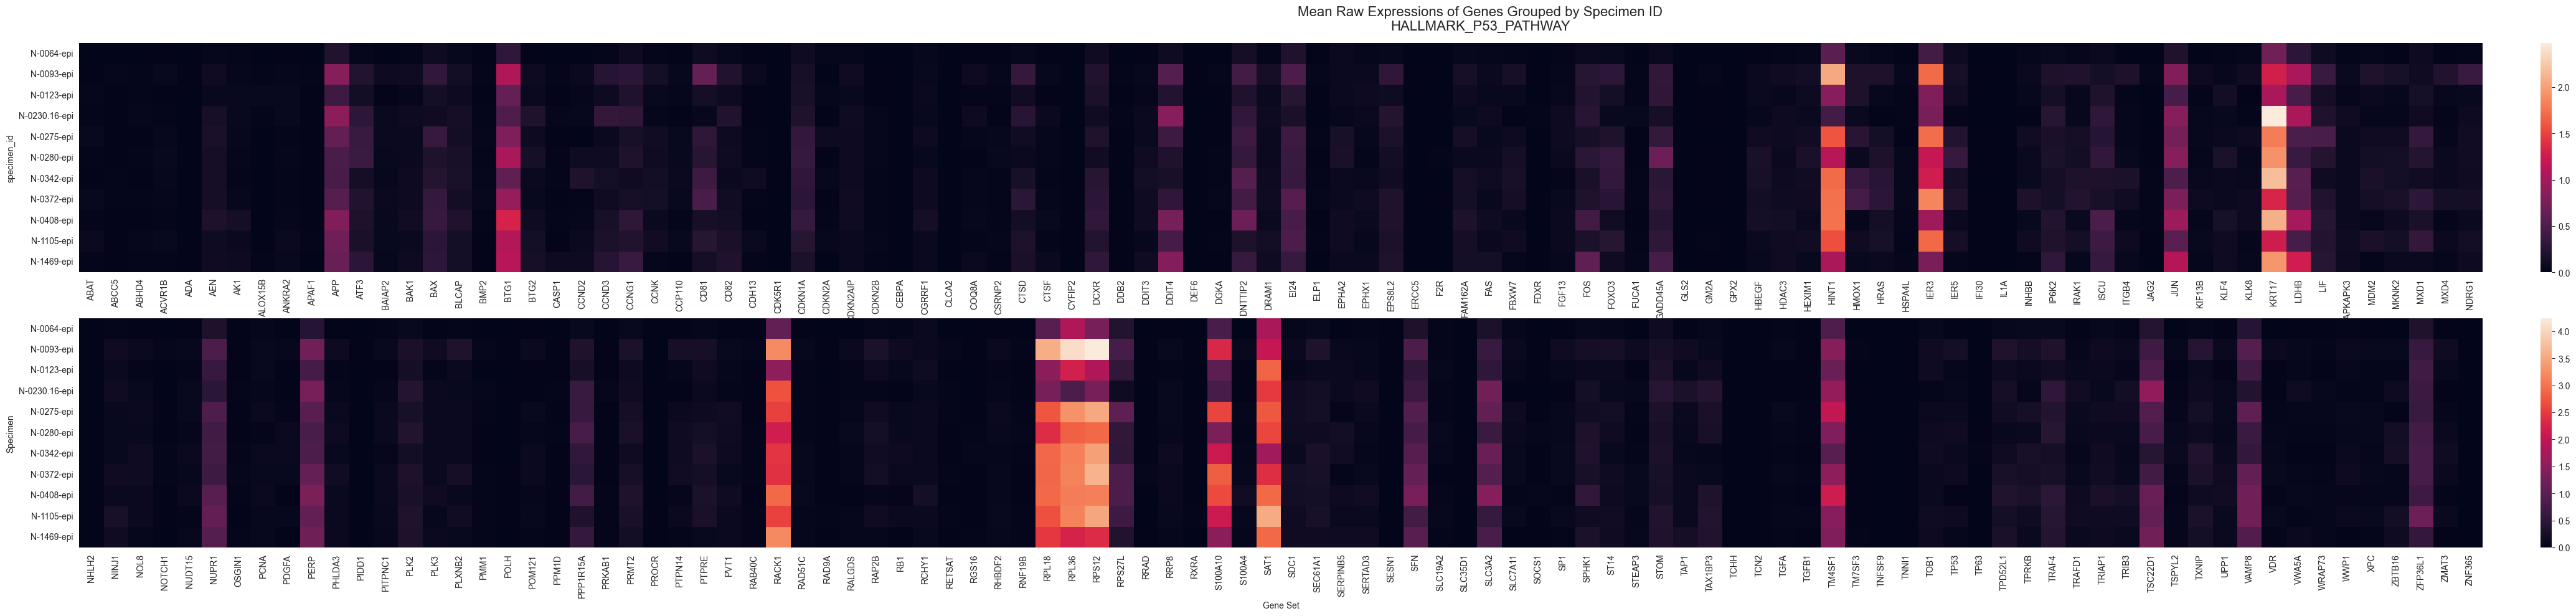

In [25]:
pathway_name = 'HALLMARK_P53_PATHWAY'
pathway_genes = pathway_to_genes[pathway_name]
pathway_heatmap(all_real, pathway_name, pathway_genes)

### 2.b. "Noise" cells

C:\Users\silly\AppData\Local\Temp\ipykernel_34936\360744347.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = pathway_df.groupby("specimen_id").mean()
C:\Users\silly\AppData\Local\Temp\ipykernel_34936\360744347.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = pathway_df.groupby("specimen_id").mean()


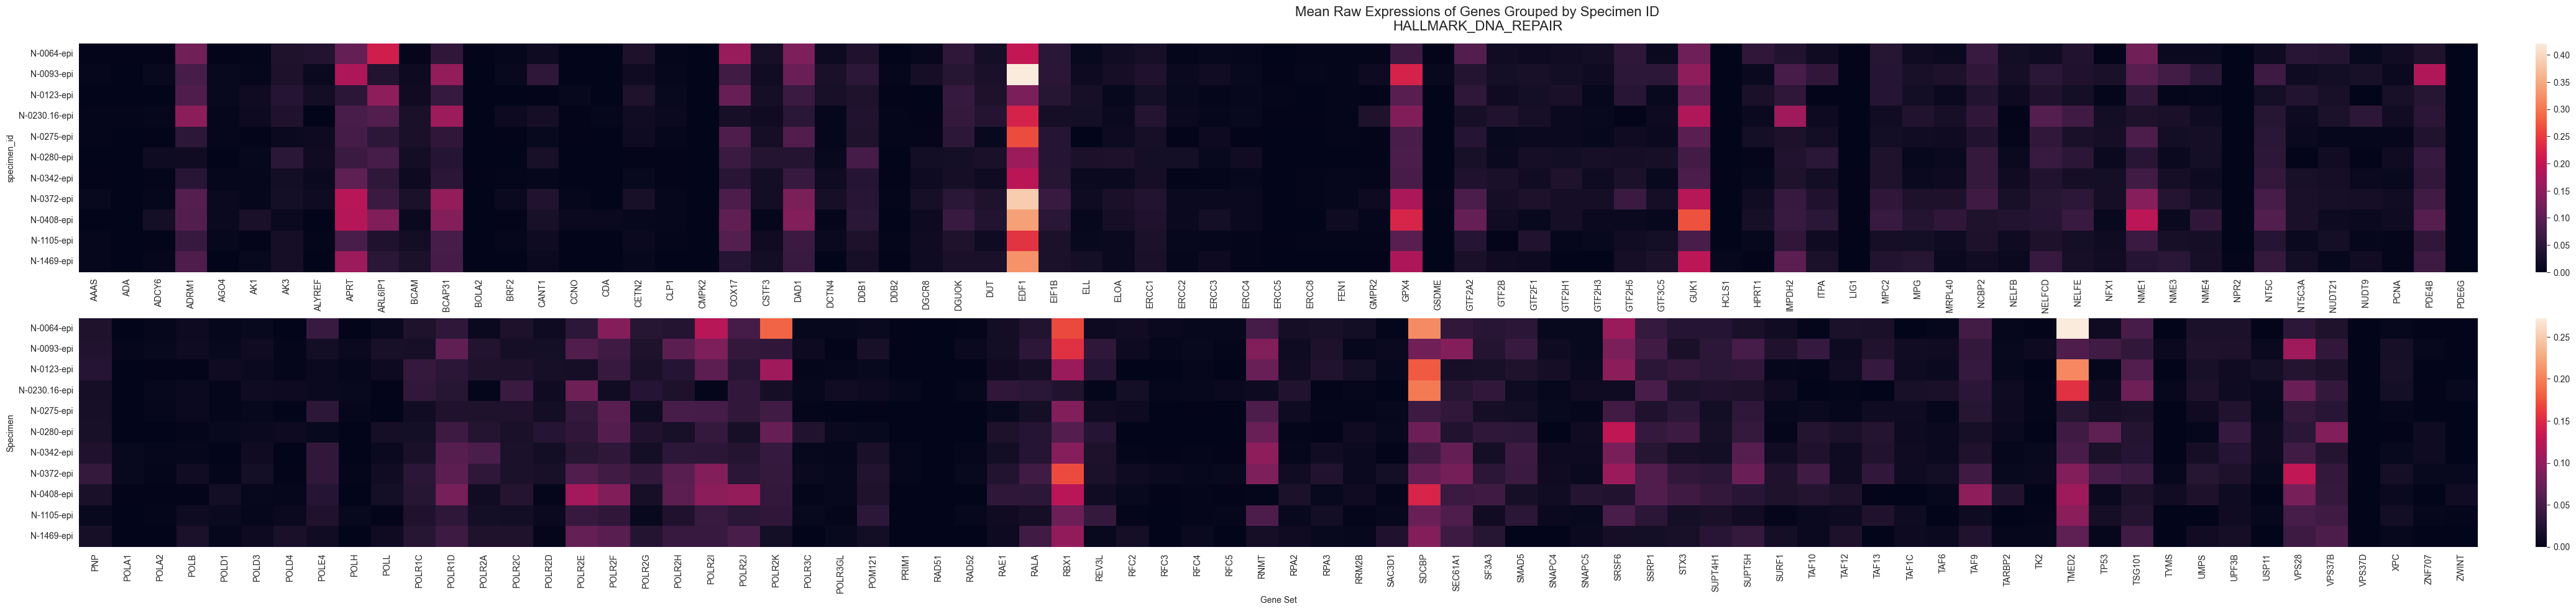

In [26]:
pathway_name = 'HALLMARK_DNA_REPAIR'
pathway_genes = pathway_to_genes[pathway_name]
pathway_heatmap(all_noise, pathway_name, pathway_genes)

C:\Users\silly\AppData\Local\Temp\ipykernel_34936\360744347.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = pathway_df.groupby("specimen_id").mean()
C:\Users\silly\AppData\Local\Temp\ipykernel_34936\360744347.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = pathway_df.groupby("specimen_id").mean()


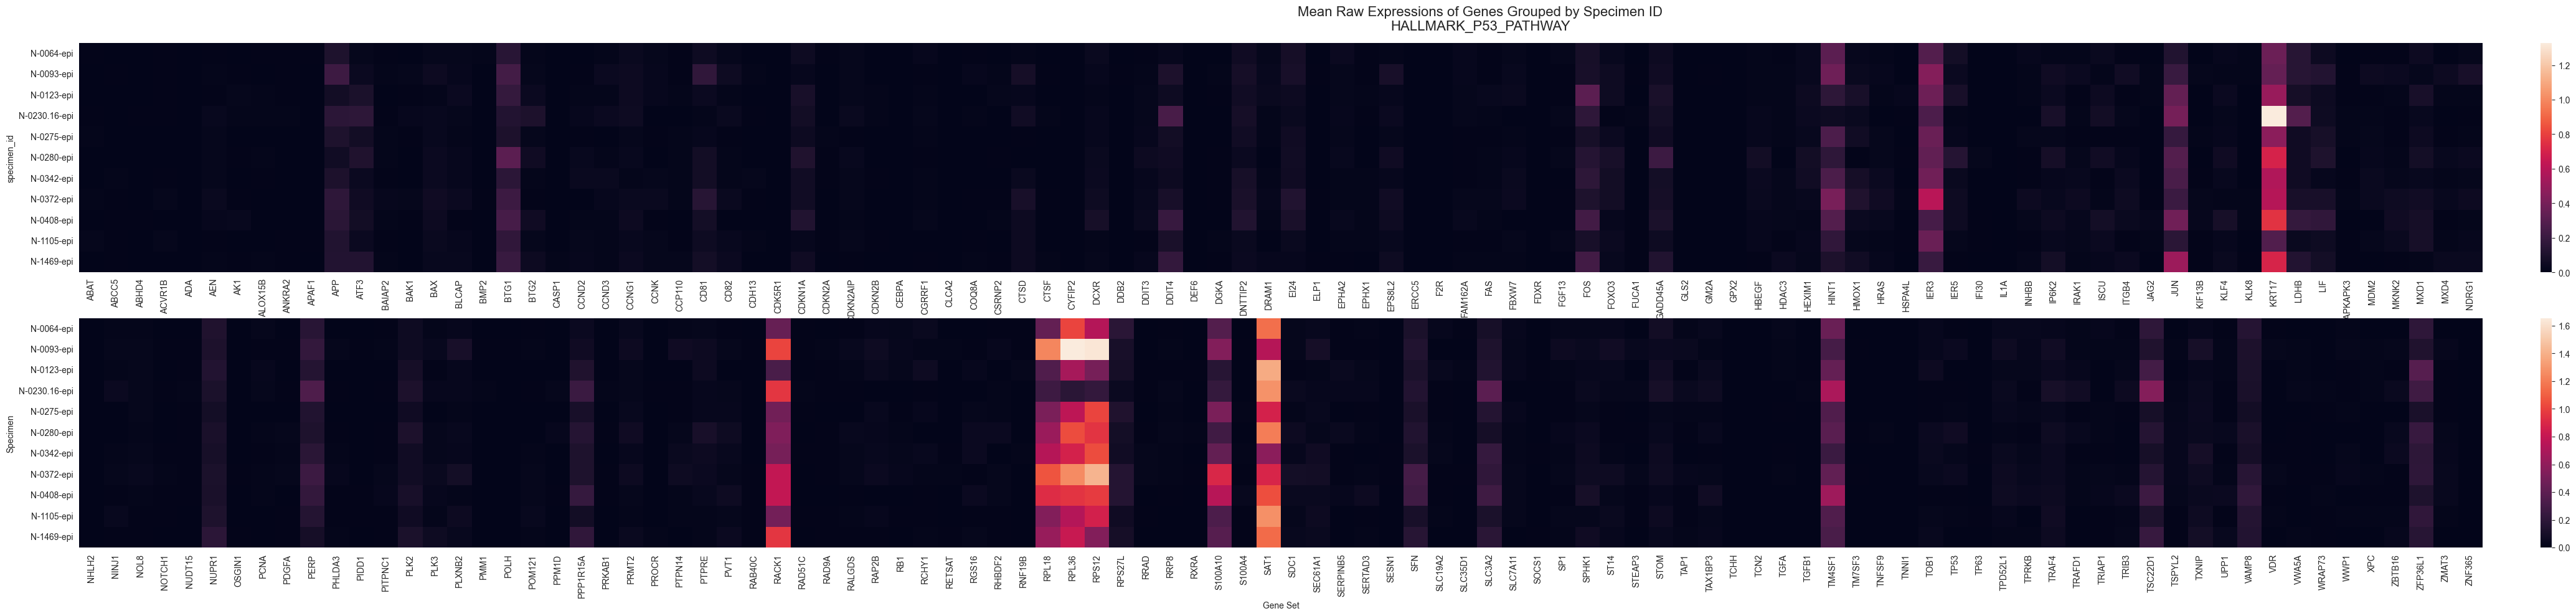

In [27]:
pathway_name = 'HALLMARK_P53_PATHWAY'
pathway_genes = pathway_to_genes[pathway_name]
pathway_heatmap(all_noise, pathway_name, pathway_genes)